In [ ]:
#| default_exp learner

In [ ]:
#| export 
import math, torch, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy

from torch import optim
import torch.nn.functional as F

from miniai.conv import *

from fastprogress import progress_bar, master_bar

In [ ]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from torch import nn, tensor
from datasets import load_dataset, load_dataset_builder
from miniai.datasets import *
import logging
from fastcore.test import test_close

In [ ]:
torch.set_printoptions(precision=2, linewidth=160, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [ ]:
logging.disable(logging.WARNING)

In [ ]:
plt.style.use('dark_background')

## Learner

In [ ]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Grab a single example from Dataset and check its shape. We will be working with flattened images, so we convert PIL to tensor and flatten it out to get 784 (28x28) long tensor

In [ ]:
ex = TF.to_tensor(dsd['train'][0][x])
ex.shape

torch.Size([1, 28, 28])

In [ ]:
torch.flatten(TF.to_tensor(dsd['train'][0][x])).shape

torch.Size([784])

In [ ]:
@inplace
def transformi(b):
    # b is a dictionary of image and label
    # import ipdb; ipdb.set_trace()
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transform=transformi)

In [ ]:
# remove number of workers during debugging
dls = DataLoaders.from_dd(tds, batch_size=bs, as_tuple=True)

dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

Let's remind ourselves how `DataLoaders.from_dd` actually works. 

```python
def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))
```
Let's first deal with the first line of code and `f` function. `f` is an internal collation function that itself returns a function returning collated `x` and `y` values from a given batch. This is how it is done:
1. `collate_dict` takes feature names from `dd['train']`: `image` and `label` and puts them into an itemgetter
2.  this itemgetter is applied to the result of a `default_collate` on a given Dataset returning a tuple of `x` and `y` values

```python
def collate_dict(ds):
    get = itemgetter(*ds.features) # get x and y values
    def _f(b): return get(default_collate(b))
    return _f
```

The second line of code (returning) can be broken down into several parts: call `get_dls` and wrap its return value into `cls`. Let's tackle it one by one.

```python
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))
```

`get_dls` takes a train and valid datasets and turns them into the respective DataLoaders (PyTorch). Our created `collate_dict` function (assigned to `f`) is passed to the DataLoader `__init__` method via `**kwargs`

Wrapping the resulting tuple of DataLoaders inside `cls` simply allows us to get them by calling .train and .vaild on our Dataloaders class.

```python
def __init__(self, *dls): self.train, self.valid = dls[:2]
```

Now we should fully understand the initial code above. We create dataloaders (train and valid), then we select train dataloader and get one batche of size 1024 from it.

```python
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb, yb = next(iter(dt))
```
During the call to iterator our collation function (`f`) comes in play and merges the 1024 element list of dictionaries into a tuple of `x` and `y` tensors.

Now let's move on to creating our first Learner framework.

##  Learner

First we create a simplified learner that still has some nice structure to it.

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        # move xb and yb to device
        self.xb, self.yb = to_device(self.batch)
        # get preds and loss
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        # if model is in training - update weights
        if self.model.training:
            with torch.no_grad():
                self.loss.backward()
                self.opt.step()
                self.opt.zero_grad()
       
        # calculate stats
        with torch.no_grad(): self.calc_stats()
        
        
    def calc_stats(self):
        # calculate accuracy,loss and ns and append to arrays
        acc = (self.preds.argmax(1) == self.yb).float().sum()
        n = len(self.xb)
        self.accs.append(acc)
        self.losses.append(self.loss * n)
        self.ns.append(n)
   
          
    def one_epoch(self, train):
        # set training / eval mode and get relevant dl
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        # loop through the dl and calculate one batch
        for self.num, self.batch in enumerate(self.dl):
            self.one_batch()
        
        # print epoch, training mode, losses and accuracy
        n = sum(self.ns)
        print(self.epoch, train, sum(self.losses).item()/n, sum(self.accs).item()/n)
        
    def fit(self, n_epochs):
        # initialize accs, losses and ns lists
        self.accs, self.losses, self.ns = [],[],[]
        
        # move model to device, set optimizer and number of epochs
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        # run epochs for training and validaton
        for self.epoch in self.epochs:
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
       

In [ ]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
# %debug
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1753048177083334 0.5986833333333333
0 False 1.1203291294642856 0.6135285714285714


In [ ]:
# learn = Learner(model, dls, F.cross_entropy, lr=0.2)
# learn.fit(1)

## Basic Callbacks Learner 

Now let's improve greatly upon our previus iteration and add Callbacks to our Learner

In [ ]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [ ]:
for i in range(10):
    try:
        _ = i%2
        if i == 2: raise CancelFitException
    except CancelFitException: print('Caught you'); break
    finally: print("Got an exception")

Got an exception
Got an exception
Caught you
Got an exception


Note that we set order variable outside `__init__` and so it belongs to the class and is shared by all instances.

In [ ]:
#|export
class Callback: order = 0

We use `getattr` to get a named attribute from an object; getattr(x, 'y') is equivalent to x.y.

In [ ]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    # loop through all the callbacks in order of 'order', 
    for cb in sorted(cbs, key= attrgetter('order')):
    # get their `method_nm` if it exists and call them on the learner
        if hasattr(cb, method_nm): getattr(cb, method_nm)(learn)
            

In [ ]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [ ]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [ ]:
hasattr(cbs[0], 'before_batch')

False

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        # get preds and losses. If training update weights
        self.xb, self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            with torch.no_grad():
                self.loss.backward()
                self.opt.step()
                self.opt.zero_grad()
        
        
    def one_epoch(self, train: bool):
        # set model mode and get relevant dl
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        # try block with `epoch` callback unless exception. 
        try:
            self.callback('before_epoch')
            for self.n, self.batch in enumerate(self.dl):
                # loop inside through batches, trying `batch` callback and calling one batch
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
        
            
    def fit(self, n_epochs):
        # set n_epochs, epochs range and optimizer
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        # try block with `fit` callback unless exception.
        try:
            # Run inside one_epoch for training and validation
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
        
        
    # callback function for Learner        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [ ]:
m,nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [ ]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


In [ ]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

```python
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))
```

In [ ]:
# 1024 * 2 because our dataloader for validation takes twice the batch size
math.ceil(60_000/1024) + math.ceil(10_000/(1024*2))

64

In [ ]:
?? Callback

Init signature:  Callback()
Docstring:      <no docstring>
Type:           type
Subclasses:     CompletionCB


In [ ]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [ ]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

In [ ]:
learn.cbs[1].count

1

## Metrics

We want to be able to use different metrics with our learner so we create a base class below.

In [ ]:
class Metric:
    def __init__(self): self.reset() # reset stats
    
    def reset(self): self.vals, self.ns = [], [] # set `vals` and `ns` to empty lists 
        
    def add(self, inp, targ=None, n=1):
        # calculate `last` and append to `vals` keeping track of `ns`
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        # return weighted sum of metric
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    # in a base class simply return inputs
    def calc(self, inps, targs): return inps

In [ ]:
class Accuracy(Metric):
    # override calc method to get accuracy
    def calc(self, inps, targs): return (inps == targs).float().mean()

In [ ]:
acc = Accuracy()
acc.add(tensor([0,1,2,0,1,2]),tensor([0,1,1,2,1,0]))
acc.add(tensor([1,1,2,0,1]),tensor([0,1,1,2,1]))
acc.value

tensor(0.45)

Basic Metric can serve as a weighted average calculator because its `calc` method simply return input back.

In [ ]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32 + 0.9*2)/(32+2),2)

(tensor(0.62), 0.62)

## Some callbacks

Let's build upon the Metric class and add some metrics defined in PyTorch.

In [ ]:
#| export
from torcheval.metrics import MulticlassAccuracy, Mean

In [ ]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [ ]:
metric.reset()
metric.compute()

tensor(nan)

Metrics are usually calculated using data that is on the `cpu`.

In [ ]:
#| export
def to_cpu(x):
    """Recursively move data to cpu"""
    # mapping case
    if isinstance(x, Mapping): return {k: to_cpu(v) for k,v in x.items()}
    # list case
    if isinstance(x, list): return [to_cpu(o) for o in x]
    # tuple case (via list)
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    # base case (tensor)
    res = x.detach().cpu()
    # cast to float if tensor.dtype was float16
    return res.float() if res.dtype == torch.float16 else res
                                          

In [ ]:
test = (tensor(1, device=def_device), tensor(2, device=def_device))
test

(tensor(1, device='cuda:0'), tensor(2, device='cuda:0'))

In [ ]:
to_cpu(test)

(tensor(1), tensor(2))

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, 
                 *ms, # list of metrics
                 **metrics, # dictionary of metrics
                ):
        # pool all unnamed metrics into a dictionary `metrics` using __name__ as key
        for m in ms: metrics[type(m).__name__] = m
        # save to self.metrics
        self.metrics = metrics
        # make a copy of metrics into `all_metrics` and add 'loss' metric, which will be Mean()
        self.all_metrics = copy(self.metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
        
    def _log(self, d): print(d)
    def before_fit(self, learn): # attach MetricsCB to a learner metrics property
        learn.metrics = self
    def before_epoch(self, learn): # reset all metrics in `all_metrics`
        for m in self.all_metrics.values(): m.reset()
    # print metrics after each epoch
    def after_epoch(self, learn):
        # save log of all metrics, using `compute` method and 3 floating points
        log = {k: f"{v.compute():.3f}" for k,v in self.all_metrics.items()}
        # add `epoch` to log and `train` mode: `train` or `eval`
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        # pass to _log
        self._log(log)
    
    def after_batch(self,learn):
        # move learner batch to cpu and unpack to x, y and all remaining values into *
        x, y, *_ = to_cpu(learn.batch)
        # loop through metric values and call `update` using `learn.preds` (on cpu)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        # update loss separately using `learn.loss` and batch size as weight
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
mn = Mean()
mn.update(tensor(5), weight=2)
mn.update(tensor(10), weight=6)
print(mn.compute()), print((5*2+10*6)/(2+6))

tensor(8.75, dtype=torch.float64)
8.75


(None, None)

In [ ]:
test = MetricsCB(1,'2',3.0,[4])
test.metrics

{'int': 1, 'str': '2', 'float': 3.0, 'list': [4]}

In [ ]:
def o(): return 1,2,3,4,5
x1, x2, *_ = o()
print(x1, _)

1 [3, 4, 5]


In [ ]:
#| export 
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        # if learn.model has attribute to - move to device
        if hasattr(learn.model, 'to'): learn.model.to(def_device)
    def before_batch(self, learn): # move batch to device
        learn.batch = to_device(learn.batch, def_device)

In [ ]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.602', 'loss': '1.183', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.700', 'loss': '0.847', 'epoch': 0, 'train': 'eval'}


In [ ]:
learn.metrics.all_metrics.values()

dict_values([<torcheval.metrics.classification.accuracy.MulticlassAccuracy object>, <torcheval.metrics.aggregation.mean.Mean object>])

## Flexible learner

Let's continue imporving upon our Learner. Below we discuss the key concepts that we will use.

1. __Contexmanager__

Context managers are objects that define the behavior to be performed when entering and exiting a context (e.g., acquiring and releasing resources). The contextmanager decorator simplifies the creation of context managers by eliminating the need to define a class with __enter__() and __exit__() methods.<br>

Inside contextmanager we use `yield` without any value. `yield` expression returns control to the whatever is using the generator. The generator pauses at this point, which means that the `@contextmanager` decorator knows that the code is done with the setup part. In other words, everything you want to do in the context manager `__enter__` phase has to take place before the yield.

Once the context exits (so the block under the with statement is done), the `@contextmanager` decorator is called for the `__exit__` part of the context manager protocol and will do one of two things:

* If there was no exception resume your generator. The generator unpauses at the yield line, and enter the cleanup phase
* If there was an exception, the decorator uses generator.throw() to raise that exception in the generator. It'll be as if the yield line caused that exception. Because we have a `finally` clause, it'll be executed before your generator exits because of the exception.

In our example the sequence is as follows:

1. with self.cb_ctx('epoch') creates the context manager and calls `__enter__` on that. 

2. The generator starts execution and tries calling `self.callback(f'before_{nm}')`

3. The `yield` expression pauses the generator, control goes back to the decorator. This takes whatever was yielded and returns that to the `with` statement, in case there is an `as target` part. Here `None` is yielded (there is only a plain `yield` expression).

4. Code below `with` statement is run and completes:
```python
for self.iter, self.batch in enumerate(self.dl):
```
<br>

5. The context manager __exit__ method is run, no exception is passed in.

6. The decorator resumes the generator, it continues where it left off.

7. The `finally` block is entered and `self.callback(f'cleanup_{nm}')` is executed

8. The generator exits, the decorator __exit__ method exits, all is done.


See https://stackoverflow.com/questions/35489844/what-does-yield-without-value-do-in-context-manager/35489897#35489897

2. __self.parameter__

Every parameter in our class is `self` which allows us to change it from anywhere.


3. __globals()__

Dictionary that store all global variables

4. Callbacks

Callbacks provides us with additional flexibility and allow us to change the behavior of a Learner by changing the callbacks

In [ ]:
globals()['bs']

1024

In [ ]:
@contextmanager
def test_cm(s):
    try:
        print('Enter context')
        yield
        print('Exit context')
    except Exception: pass

In [ ]:
with test_cm('apple'):
    print(1+1)

Enter context
2
Exit context


In [ ]:
class Learner:
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD): 
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def cb_ctx(self, nm):
        # try block with callbacks `before_nm` and `after_nm`. 
        # checks for exception in globals() and runs `cleanup` in finally block
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
            
    def one_epoch(self, train: bool):
        """Train for one epoch"""
        # set the model to the right mode and select relevant dataloader
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        # enter context for an epoch
        with self.cb_ctx('epoch'):
            # loop through batches
            for self.iter, self.batch in enumerate(self.dl):
                # enter context for a batch and run predict and get loss
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    # if training mode update weights       
                    if train: 
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        # cast cbs to L
        cbs = fc.L(cbs)
        # if additional cbs are provided, pass it to the Learner for fitting and remove later
        for cb in cbs: self.cbs.append(cb)
        # try block
        try:
            # create number of epochs, their range and optimizer
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), lr=self.lr if lr is None else lr)
            # enter fit context
            with self.cb_ctx('fit'):
                # train and validate (using torch.no_grad()(f-n) for a given number of epochs
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    # acts like a context manager with grad calculation disabled
                    if valid: torch.no_grad()(self.one_epoch)(False)
       
        # remove cbs in finally block
        finally: 
            for cb in cbs: self.cbs.remove(cb)
            
      
    # __getattr__ method to call predict, get_loss, backward, step and zero_grad directly on Learner using callback
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            # partial (instead of self.callback(name)) because we want to return a function, not a value (which is None)
            # run callback method that loops through all callbacks and calls those that have a specified name. For example `predict` from TrainCB
            return partial(self.callback, name)
        # else raise AttributeError
        else: raise AttributeError(name)
       
    # run callback on a Learner
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    # for ease of reference return model mode
    @property
    def training(self): return self.model.training

In [ ]:
#| export
class TrainCB(Callback):
    """Basic training callback"""
    # n_inp allows to train models with more than one input
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): 
        # import ipdb; ipdb.set_trace()
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
#| export
class ProgressCB(Callback):
    # decrease callback order priority
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    
    def before_fit(self, learn):
        # import ipdb; ipdb.set_trace()
        # create master_bar and set it to both mbar and learn.epochs
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        # substitute _log method of learn's metrics (simple print) with progress bar
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        
    def before_epoch(self, learn): 
        # ??
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: 
                self.mbar.update_graph(
                    [[fc.L.range(self.losses), self.losses],
                     [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), 
                      self.val_losses]])
                   
    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                # import ipdb; ipdb.set_trace()
                # append to validation losses
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph(
                    # plot training losses
                    [[fc.L.range(self.losses), self.losses],
                     # plot validation losses, converting from epochs to batches
                     [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), 
                      self.val_losses]])

In [ ]:
model = get_model()

accuracy,loss,epoch,train
0.596,1.167,0,train
0.729,0.794,0,eval
0.744,0.710,1,train
0.764,0.654,1,eval


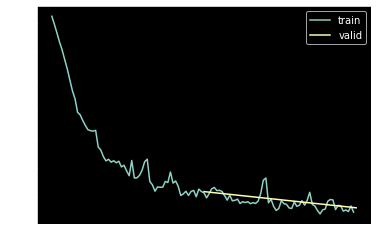

In [ ]:
# %debug
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2, cbs=[ProgressCB(plot=True)])

In [ ]:
learn.cbs

(#3) [<__main__.TrainCB object>,<__main__.DeviceCB object>,<__main__.MetricsCB object>]

accuracy,loss,epoch,train
0.778,0.615,0,train
0.799,0.575,0,eval
0.802,0.560,1,train
0.799,0.564,1,eval


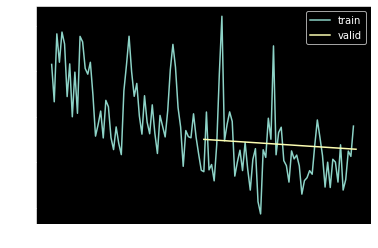

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with a decorator in this updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`.

In [ ]:
#| export 
class with_cbs:
    def __init__(self, nm: str): self.nm = nm
    def __call__(self, f):
        # create internal _f that uses try block and calls `before_nm` and `after_nm` callbacks
        # checkng for exception in globals() and finally calling cleanup
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                # we need to pass `o` as well as *args will not include it
                # because it is separately stored to o
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [ ]:
#| export
class Learner:
    def __init__(self, 
                 model, # model to be used for training
                 dls=(0,), # dataloaders
                 loss_func=F.mse_loss, # loss-function
                 lr=0.1, # learning rate to ber used
                 cbs=None, # callbacks
                 opt_func=optim.SGD # optimizer
                ):
        cbs = fc.L(cbs)
        fc.store_attr()
        
    
    @with_cbs('batch')
    def _one_batch(self):
        # predict followed by an after callback
        self.predict()
        self.callback('after_predict')
        # get loss followed by an after callback
        self.get_loss()
        self.callback('after_loss')
        # if training
        if self.training:
            # backward followed by an after callback
            self.backward()
            self.callback('after_backward()')
            # step followed by an after callback
            self.step()
            self.callback('after_step')
            # zero grad
            self.zero_grad()
    
    @with_cbs('epoch')
    def _one_epoch(self):
        # iterate through dls calling one batch
        for self.iter, self.batch in enumerate(self.dl):
            self._one_batch()
        
    
    def one_epoch(self, training):
        # set the model mode and get dl
        self.model.training = training
        self.dl = self.dls.train if training else self.dls.valid
        # run one epoch
        self._one_epoch()
    
    
    @with_cbs('fit')
    def _fit(self, train: bool, valid: bool):
        # loop through epochs for train and valid
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)
    
        
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        # cast callbacks to L
        cbs = fc.L(cbs)
        # add extra temporary callbacks to the Learner callbacks
        for cb in cbs: self.cbs.append(cb)
        # try block
        try:
            # create number of epochs, their range, lr (if not passed) and optimizer
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            lr = self.lr if lr is None else lr
            self.opt = self.opt_func(self.model.parameters(), lr)
            # fit train and valid
            self._fit(train, valid)
            
        # remove cbs in finally
        finally: [self.cbs.remove(cb) for cb in cbs]
     

    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        
        else: raise AttributeError(name)
        
        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
        
        
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.615,1.184,0,train
0.718,0.778,0,eval


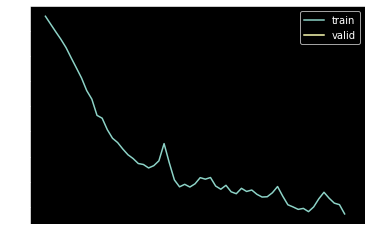

In [ ]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainLearner and MomentumLearner

In [ ]:
#| export
class TrainLearner(Learner):
    # note that we sublcass Learner and implement below methods directly in it
    # not through cbs. So __getattr__ will not be called
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
#| export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt=optim.SGD, mom=0.85):
        # save mom and call super init
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt)
    def zero_grad(self):
        # update zero_grad method to account for momentum - not zero grads completely but multiply by a constant
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.673,0.945,0,train
0.785,0.592,0,eval


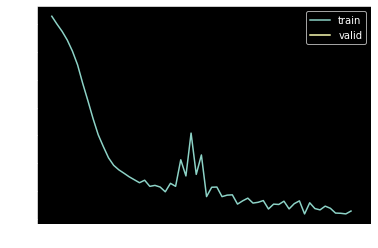

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit()

## LRFinderCB

Let's implement a learning-rate finder callback that allows us to find the maximum learning rate that can result in training of the model.

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        # create lists for storing lrs and losses
        self.lrs, self.losses = [], []
        # starting value for a loss (self.min)
        self.min = math.inf
        
        
    def after_batch(self, learn):
        # if not in training - CancelEpoch
        if not learn.training: raise CancelEpochException()
        # append learning rate and loss (remember to move to cpu) to the lists
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        # update min loss or cancel fit if it exceeds min by a factor of 3
        if loss > self.min * 3: raise CancelEpochException
        if loss < self.min: self.min = loss 
        # update learning rate for each parameter group by a factor lr_mult
        for o in learn.opt.param_groups: o['lr'] *= self.lr_mult

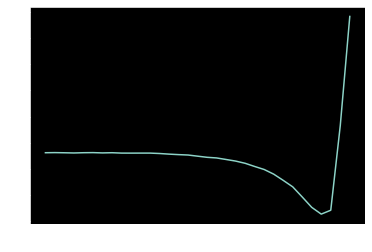

In [ ]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

## ExponentialLR

Now we can use a Pytorch built-in scheduler

In [ ]:
#| export 
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#| export 
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        # screate a sched(uler)
        self.sched = ExponentialLR(learn.opt, self.gamma)
        # create lists for storing lrs and losses
        self.lrs, self.losses = [],[]
        # starting value for a loss (self.min)
        self.min = math.inf
        
    def after_batch(self, learn):
        # if not in training - CancelEpoch
        if not learn.training: raise CancelEpochException()
        # append learning rate and loss (remember to move to cpu) to the lists
        loss = to_cpu(learn.loss)
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        self.losses.append(loss)
        # update min loss or cancel fit if it exceeds min by a factor of 3 or isnan
        if (loss > self.min * self.max_mult) or math.isnan(loss): raise CancelFitException()
        # scheduler step
        if loss < self.min: self.min = loss
        self.sched.step()
        
    def cleanup_fit(self, learn):
        # plot on a log scale
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

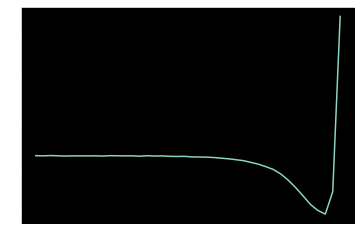

In [ ]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

`lr_find` was added in lesson 18. It's just a shorter way of using `LRFinderCB`.

In [ ]:
#| export 
@fc.patch
def lr_find(self: Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

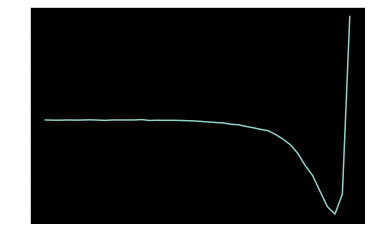

In [ ]:
cbs = [DeviceCB()]
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()